# Convolution Neural Network Using TensorFlow

TensorFlow is Google Brain Teams's open source libary for machine learning. Here I will code a convolutional neural network to classify the fashion MNIST dataset as the regular MNIST dataset has been done too many times. I decided to use a convolutional neural network as it is better for working with images. Convolutional neural networks use filters in order to detect features that can help with the training.

# TEMPORARY: I did not make any of the images here they are placeholders untill I make my own

## Processing the data

In [1]:
import gzip as gz
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random

The dataset I used contained 60000 images of 10 different types of fashion items such as clothes and shoes an can be found at: https://github.com/zalandoresearch/fashion-mnist with each image labeled with what kind of fashion item it is. It is the same as the MNIST dataset but with fashion instead. It uses the exact same format as the MNIST dataset just with different images. First the files are loaded

In [7]:
train_x = gz.open("Data/train-images-idx3-ubyte.gz", "r")
train_y = gz.open("Data/train-labels-idx1-ubyte.gz", "r")

We set the size of the images (which are 28x28) and the number of images

In [8]:
img_size = 28
num_images = 60000

The data is stored in a sequence of bytes. The first 16 bytes are read but not assigned any value since they do not contain any usable data (as said in the original MNIST dataset website: http://yann.lecun.com/exdb/mnist/) then it reads the data in such a way that every training example is separated. Finally it reshapes it into a usable format.

In [9]:
train_x.read(16)  # First 16 bytes contain unecessary information
train_x = train_x.read(img_size * img_size * num_images)
train_x = np.frombuffer(train_x, dtype=np.uint8())
train_x = train_x.reshape(num_images, img_size, img_size)

Same concept for the labels but it is converted to a list instead of a numpy array.

In [10]:
train_y.read(8)  # First 8 bytes contain unecessary info
train_y = train_y.read(num_images)
train_y = np.frombuffer(train_y, dtype=np.uint8)
train_y = train_y.tolist()

Here each label is assinged a row (but idealy should be row) matrix with all 0s expect for one element. Each element shows the probability of it being that label so for example a picture of a pullover is labeled as a 2 (labels range from 0 to 9) then the third element (python starts counting from 0 so the first element is indexed as the 0th element) is going to be a 1.
$$
\begin{bmatrix}
P(Shirt) \\
P(Trouser) \\
P(Pullover \\
\vdots \\
P(Ankle boot)
\end{bmatrix}
$$

In [11]:
for i in range(len(train_y)):
    index = train_y[i]
    train_y[i] = np.zeros((1, 10), dtype=np.float32)
    np.put(train_y[i], index, 1)

Then the data is saved

In [12]:
np.save("Data/train_features.npy", train_x)
np.save("Data/train_labels.npy", train_y)

The image data can be visualy shown.

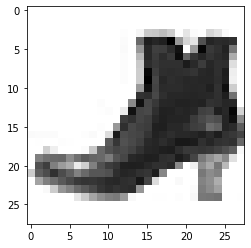

In [17]:
plt.imshow(tf.squeeze(train_x[np.random.randint(0, len(train_y))]), cmap="binary")
plt.show()

## How CNNs work (basically)

Image data is repressented as a sequence of pixels with the values ranging from 0 to 255 pre normalization repressenting the brightness values. The dimensions are the width by height by the number of colour channels so for a 6x6 RGB image (so it will be 6x6x3) it would be repressented like this with each square being the RGB value of the corresponding layer (so the values in the first layer would repressent the red values).

![6x6x3.png](Images/6x6x3.png)
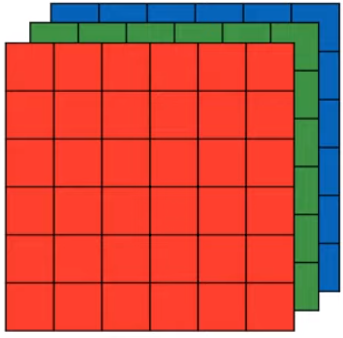

With my dataset the images only have one colour channel so they are greyscale and are 28x28x1. This will be the dimensions of each training example. The input is first passed through a convolution layer (you cave more but it is computationally expensive so I chose to only have 1) then a flattening layer to turn the output intot a rank 1 tensor, and finally through a regular network which are referred to as fully connected to the final output.

The convolution layer works by passing a filter of a certain size (in this case 3x3) and going through every position over the input and ouputing another image that hopefully has detected features which the fully connected layers can use. The filter (or kernel) in this example is:
$$
\begin{bmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 1
\end{bmatrix}
$$

![CNN_gif.gif](Images/CNN_gif.gif)
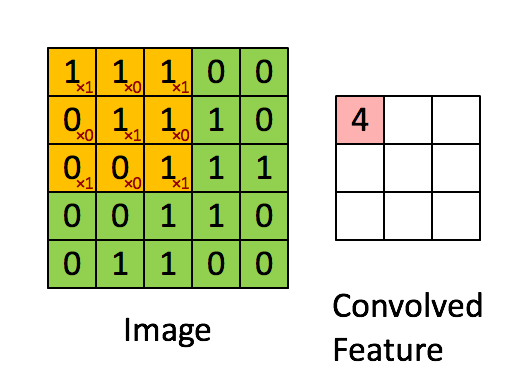

In general the formula for the prediction with coordinates $ (x, y) $ with $ h $ being the prediction at that coordinate and $ x_{i,j} w_{i,j} $ being the input and convolution kernel value respectivaly with kernel width and height $ m $
$$
h_{x,y} = \sum_{i=1}^{m}\sum_{j=1}^{m}w_{i, j}x_{x+i-1, y+j-1}
$$
An input can go through multiple filters resulting in multiple outputs which then get stacked together into a new volume. 


![Convolution_over_volumes.png](Images/Convolution_over_volumes.png)
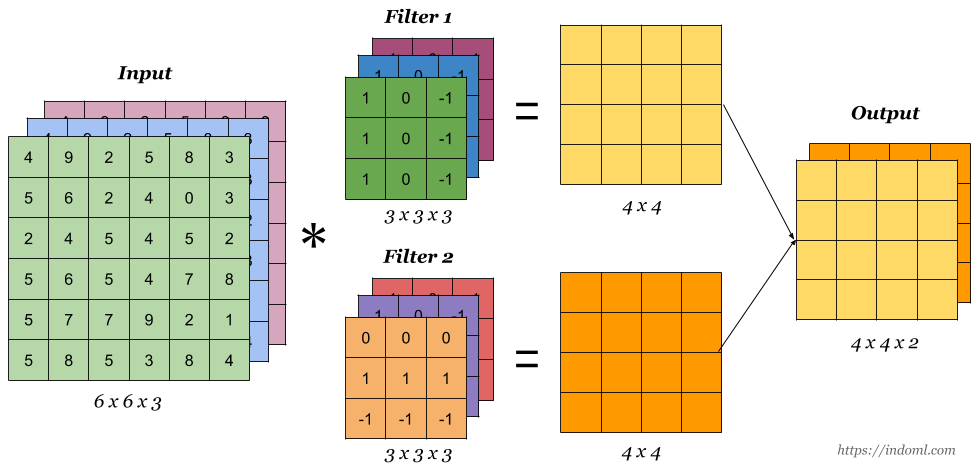

After this the output is passed through a max pooling filter wich essentially does the same thing as a convolutional filter but instead outputs the max value of the area it covers. This essentially takes out the areas that the computer thinks there are important features and puts them into an output. It also reduces the dimensions of its outputs which increases preformance.

![MaxPooling.png](Images/MaxPooling.png)
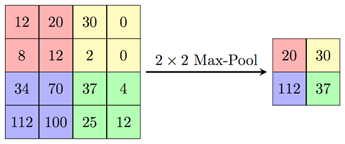

Lastly the output is passed through an activation function, usually Relu, to add some non-linearity, just like in a fully connected layer.

## Adam optimization

The adam optimization algorithm combines two other optimization algorithms namely gradient descent with momentum and RMSProp. To explain these algoeitms I have to first explain exponetionally weighted averages.

## The model

First the data is loaded and converted to tensors. A new axis is added to repressent the amount of colour channels so the dimension in general are: (width $\times$ height $\times$ number of colour channels). The data is shuffled which makes the machine learn to fit all the data not just the first types, and batched so that I don't get an out of memory issue.

In [31]:
train_x = np.load("Data/train_features.npy")
train_y = np.load("Data/train_labels.npy")
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
train_x = train_x / 255.0
train_x = train_x[..., tf.newaxis]
train_y = tf.convert_to_tensor(train_y, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(1000).batch(32)

I wanted to try mimic some well known CNN architectures but they performed very poorly on my computer so I made a simple one with a convolution layer with 16 3x3 kernels that get passed to a max pooled layer then flattened and finally through some fully connected layers. The last layer uses the softmax activation function. This function essentially turns the logits, essentially "probabilities" that range between $-\infty$ to $\infty$ but probabilities range from 0 to 1 so we want to "normalize" them, in the final layer into probabilities that when all the elements are added up the end result is 1, which makes interpreting the output as a matrix of probabilities more reasonable. The softmax function is with $M$ being the number of classes:
$$
S_i(\vec{x}) = \frac{e^{x_i}}{\sum_{k=1}^M e^{x_k}}
$$
Say for example we have an output vector like this (before being passed through an activation function):
$$
\begin{bmatrix}
7.3 \\
1.5 \\
6.9
\end{bmatrix}
$$
We can see that the elements do not add up to one and that each element can not be a probability, so we have to "convert" these logits into probabilities. If we apply the old sigmoid activation function ($\frac{1}{1+e^{-x}}$) on each element then we get:
$$
\begin{bmatrix}
0.999 \\
0.816 \\
0.999
\end{bmatrix}
$$
Which clearly the elements do not add up to 1 so we need to pass it through a function that scales all the elements so that they add up to 1 and so that the big values become bigger and small values to be smaller, as bigger values means that the computer is more certain that the input should be from that class. We use this function with $M=3$:
$$
S_i(\vec{x}) = \frac{\beta^{x_i}}{\sum_{k=1}^M \beta^{x_k}}
$$
$\beta$ can be any real number and the higher it is the bigger the difference in magnitude between high and low values will be. We use $e$ as it is relatively big and $e^x$ has a nice derivative. So if we pass the example output through softmax we get:
$$
\begin{bmatrix}
0.6 \\
0.002 \\
0.4
\end{bmatrix}
$$
Which roughly adds up to 1 due to some rounding, but we can see the element with the highest value before softmax is much bigger than the second biggest one.

In [32]:
class TrainModel(tf.keras.Model):
    def __init__(self):
        super(TrainModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, 3, activation="relu")
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation="relu")
        self.d2 = tf.keras.layers.Dense(32, activation="relu")
        self.d3 = tf.keras.layers.Dense(10, activation="softmax")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

model = TrainModel()

I defined the loss function to be the categorical crossentropy loss which essentially calculates the loss of the element of an output that is supposed to be 1. The loss function is:
$$
L(y, \hat{y}) = -\sum_{i=1}^M y_i \ln(\hat{y}_i)
$$
Where $y$ is the labels matrix, $\hat{y}$ is the prediction matrix, and $M$ is the number of labels (in the case of this dataset it is 10). For better intuition heres an example. Say we have a dataset with 3 labels and the label matrix of one of the training examples is:
$$
y = \begin{bmatrix}
0 \\
0 \\
1
\end{bmatrix}
$$
We run that training example through a model and get this matrix as an output:
$$
\hat{y} = \begin{bmatrix}
0.5 \\
0.4 \\
0.1
\end{bmatrix}
$$
We can see that the model did a bad job so we can expect a high loss for that training exmaple. If we run this through the categorical cross entropy function:
$$
L(y, \hat{y}) = -\sum_{i=1}^3 y_i ln(\hat{y}_i)
$$
We get:
$$
L(y, \hat{y}) = -(0 \ln(0.5) + 0 \ln(0.4) + 1 \ln(0.1)) = -\ln(0.1) \approx 2.3
$$
Which is a high loss as the predicted output is very wrong. This function only cares about how well the element of the output matrix that is supposed to be 1 did. This is because in the end the computer will only care about which element is the highest so we only care about maximizing the one we want. 

In [33]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
accuracy = tf.keras.metrics.Accuracy()  # The percentage of predictions that are correct
train_cost = tf.keras.metrics.Mean()

To train the model I used TensoFlow's gradient tape, which is an automatic differentiation algorithm which calculates the derivatives of a function (can be multivariable as well) at a point. For an example finding the value of the derivative of:
$$
f(x) = 2x^2 + 5x
$$
at $x=5$ which should be 25 as $f'(x) = 4x + 5$ and $f'(5) = 4(5) + 5 = 25$

In [21]:
x = tf.constant(5.0)  # The derivative at what input
with tf.GradientTape() as g:  # Gradient tape object
  g.watch(x)  # Which variable to watch
  y = 2*x**2 + 5*x  # The function and the variable x is "watched"
dy_dx = g.gradient(y, x)  # Compute the gradient

In [22]:
dy_dx.numpy()

25.0

Gradient tape can handle much more complex tasks like finding all the partial derivatives for each layer in the model. This is what we need to train the model. The variables that we want to be trained are automatically watched. The model gets trained with the Adam optimization algorithm.

In [34]:
@tf.function  # This just increases performance
def TrainStep(data_in, data_out):
    with tf.GradientTape() as g:
        preds = model(data_in)  # Make a prediction
        loss_funct = loss(data_out, preds)  # Find the loss for that training example
    gradients = g.gradient(loss_funct, model.trainable_variables)  # Compute all the partial derivatives
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))  # Apply the gradients to the trainable variables (like weights and biases)
    accuracy(tf.squeeze(data_out), preds)
    train_cost(loss_funct)

In [35]:
def train(dataset, epochs=1):
    for epoch in range(epochs):
        accuracy.reset_states()
        train_cost.reset_states()

        for img, labels in dataset:
            TrainStep(img, labels)

        placeholder = "Epoch: {}, Cost: {}, Accuracy: {} %"
        print(placeholder.format(epoch + 1, train_cost.result(), np.around(accuracy.result()*100, decimals=1)))

In [38]:
train(train_ds, 1)

Epoch: 1, Cost: 0.009977494366466999, Accuracy: 99.4000015258789 %


In [21]:
model.save("Fashion.model")

INFO:tensorflow:Assets written to: Fashion.model\assets


In [25]:
model = tf.keras.models.load_model("Fashion.model")

In [20]:
model.save_weights("weights")

In [36]:
model.load_weights("weights")